# Types of variable distributions in Amex dataset

In [5]:
%config IPCompleter.use_jedi=False

In [6]:
%cd ..

/data/mas322/amex-project


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import cupy
import cudf
import yaml
from datetime import datetime
import sklearn
from tqdm.notebook import tqdm
from src.lib.experimentation import load_numpy_data

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)


In [11]:
fill_dict = {
    'nan' : -64,
    'pad_categorical' : -64,
    'pad_numeric' : -64,
}

train_loader, _ = load_numpy_data(os.path.join(cfg['dataset_directory'], 'derived', 'processed-splits'), [], fill_dict=fill_dict, batch_size=10000)

In [16]:
X_train = []
for X, _ in train_loader:
    # skip the categorical features
    X_train.append(X.detach().numpy()[:, :, 11:])
X_train = np.concatenate(X_train, axis=0)
X_train.shape

(458913, 13, 177)

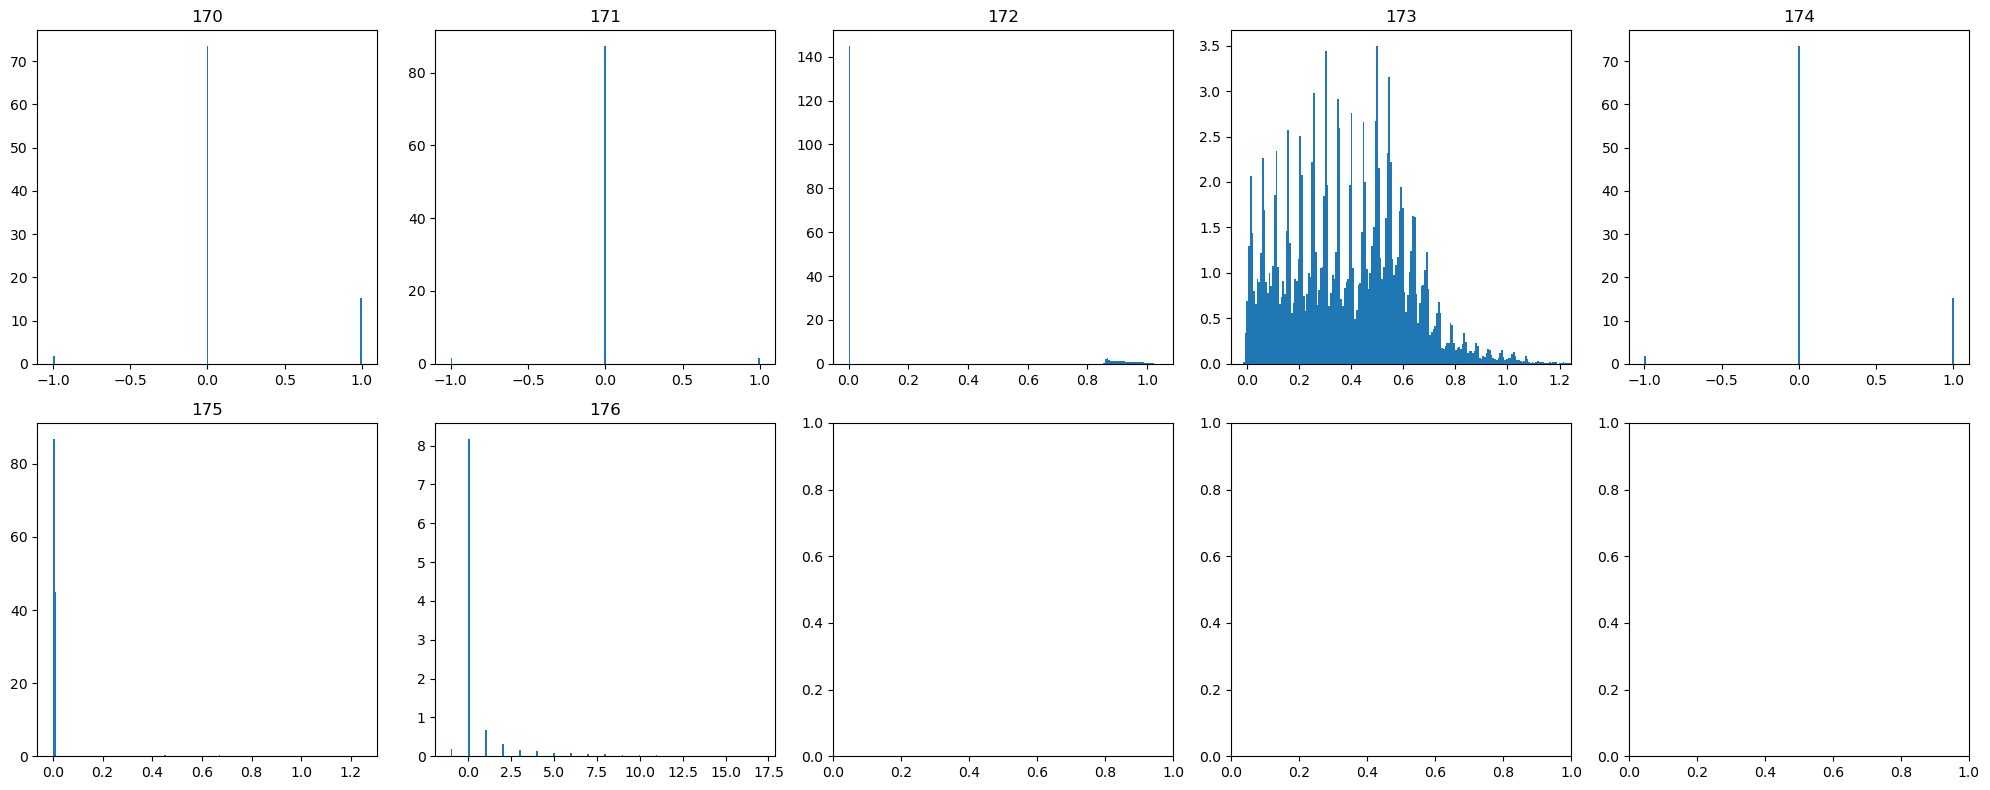

In [55]:
def plot_var(ax, xs):
    # remove missing values and outliers
    xs = xs[xs != -64]
    lower, upper = np.quantile(xs, 0.0025), np.quantile(xs, 1-0.0025)
    bins = np.linspace(lower - (upper - lower) * 0.05, upper + (upper - lower) * 0.05, 200)
    ax.hist(xs, bins=bins, density=True)
    ax.set_xlim([lower - (upper - lower) * 0.05, upper + (upper - lower) * 0.05])

NROWS = 2
NCOLS = 5
OFFSET = 17
TIMESTEP = 0
    
fig, axs = plt.subplots(ncols=NCOLS, nrows=NROWS, figsize=(20, 8))
for idx in range(OFFSET * NROWS * NCOLS, (1 + OFFSET) * NROWS * NCOLS):
    if idx >= 177: break
    i, j = idx // NCOLS - OFFSET * NROWS, idx % NCOLS
    plot_var(axs[i, j], X_train[:, TIMESTEP, idx])
    axs[i, j].set_title(idx)
fig.tight_layout()
plt.show()

## Analysing the classes

Raw text:

```
Skewed normal (with outlier):
(26), 39, 57, 68, (123, 125, 130, 137), (145), 153

Left and right half:
17, 19, 24, 46, 47, 52, 53

Left-half of normal distribution:
2, 7, 8, 9, 11, 29, 36, 40, 43, 44, 48, 50, 64, 67, 70, 71, 72, 76, 91, 127, 135, 136, 159

Left-half of of skewed normal distribution:
1, 20,  22, 30, 31, 38, 75, 104, 144, 147, 148, 149, 162

Right-half of normal distribution:

Right-half of of skewed normal distribution:
0, 150

One extreme value:
6, 13, 14, 18, 33, 34, 41, 51, 58, 60, 61, 69, 73, 74, 77, 80, 81, 82, 87, 89, 90, 92, 94, 95, 96, 98, 99, 102, 107, 108, 109, 110, 111, 113, 114, 118, 119, 120, (124, 126), 134, 138, 141, 158, 161, 163, 166, 167, 168, 169, 172, 175

Multiple spikes and normal mode:
3, 10, 23, 25, 37, 45, 49, 59, 63, 65, 66, 78, 79, 83, 93, 116, 133, 146, 151, 152, 176

Multiple spikes/modes:
4, 21, 32, 54, 55, 56, 62, 84, 85, 88, 97, 100, 112, 117, 122, 129, 132, (140), 143, 154, 155, 156, 157, 160, 170, 171, 174

Multiple modes skewed normal:
12, 131, 165, 173

Multiple modes normal:
16, 28

Other:
5, 15, 27, 35, 42, 86, 101, 103, 105, 106, 115, 121, 128, 139, 142, 164
```

In [67]:
group1 = [26, 39, 57, 68, 123, 125, 130, 137, 145, 153]
group2 = [17, 19, 24, 46, 47, 52, 53]
group3 = [2, 7, 8, 9, 11, 29, 36, 40, 43, 44, 48, 50, 64, 67, 70, 71, 72, 76, 91, 127, 135, 136, 159]
group4 = [1, 20,  22, 30, 31, 38, 75, 104, 144, 147, 148, 149, 162]
group5 = [0, 150]
group6 = [6, 13, 14, 18, 33, 34, 41, 51, 58, 60, 61, 69, 73, 74, 77, 80, 81, 82, 87, 89, 90, 92, 94, 95, 96, 98, 99, 102, 107, 108, 109, 110, 111, 113, 114, 118, 119, 120, 124, 126, 134, 138, 141, 158, 161, 163, 166, 167, 168, 169, 172, 175]
group7 = [3, 10, 23, 25, 37, 45, 49, 59, 63, 65, 66, 78, 79, 83, 93, 116, 133, 146, 151, 152, 176]
group8 = [4, 21, 32, 54, 55, 56, 62, 84, 85, 88, 97, 100, 112, 117, 122, 129, 132, 140, 143, 154, 155, 156, 157, 160, 170, 171, 174]
group9 = [12, 131, 165, 173]
group10 = [16, 28]
group11 = [5, 15, 27, 35, 42, 86, 101, 103, 105, 106, 115, 121, 128, 139, 142, 164]

groups = [group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11]

# sanity check that all numeric values is included
all_ell = [j for sub in groups for j in sub]
assert len(all_ell), len(list(set(all_ell))) == (177, 177) and "No dupes"
assert list(sorted(all_ell)) == list(range(177)) and "All elements included"




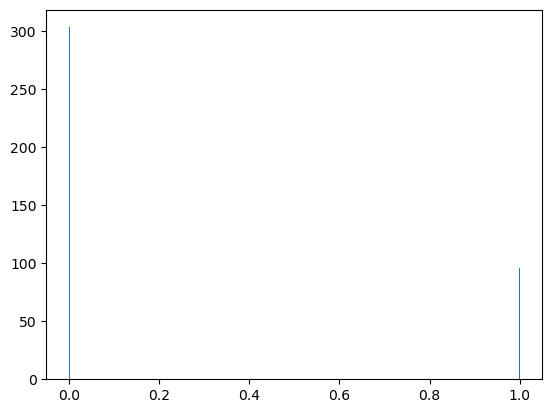

In [24]:
fig, ax = plt.subplots()
plot_var(ax, X_train[:, 0, 32])